In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

from fastai.vision.gan import *

---

In [3]:
batch_size = 12
bs = batch_size

# unet encoder architecture
arch = models.resnet34(pretrained=False)

# image size
size = 256

# Create the data loader (ImageDataBunch)

In [4]:
data_loader = (
    ImageImageList.from_folder('../images/')
    .filter_by_func(lambda path: 'lowres' in path.parent.as_posix()) # filter to have only /lowres/ as source
    .split_by_folder()                                               # use the folders to split in train/valid
    .label_from_func(lambda path: path.parents[1]/'hires'/path.name) # change /lowres/ to /hires/ to match source with target
    
    .databunch(bs=batch_size)
    .normalize(do_x=True, do_y=True) # convert the LabelLists in ImageDataBunch and normalize both X and Y
)

# number of classes
# I don't know why 3 (based on lesson7-superres-gan notebooks)... 
# the unet_learner need a value for c.
data_loader.c = 3

data_loader

ImageDataBunch;

Train: LabelList
y: ImageItemList (5343 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images
x: ImageImageList (5343 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images;

Valid: LabelList
y: ImageItemList (248 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images
x: ImageImageList (248 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images;

Test: None

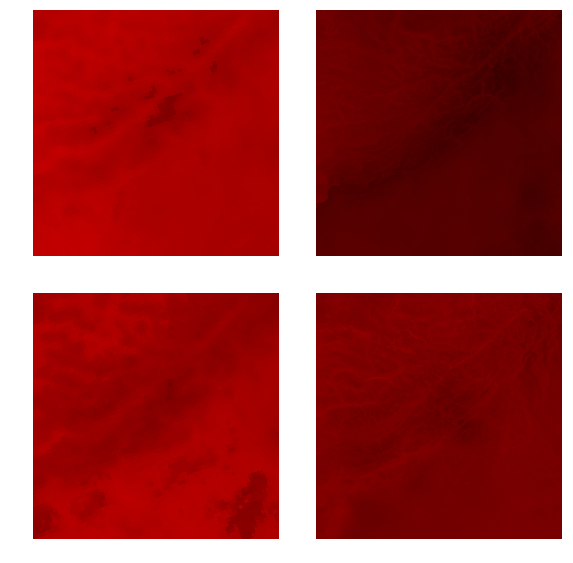

In [6]:
data_loader.show_batch(2)

---

# UNET

In [7]:
# weight decay
wd = 1e-3

y_range = (-3.,3.)

loss_gen = MSELossFlat()

---

In [10]:
def create_gen_learner():
    return unet_learner(data_loader, arch, 
                        wd=wd, blur=True, norm_type=NormType.Weight, self_attention=True, 
                        y_range=y_range, loss_func=loss_gen)

In [11]:
learn_gen = create_gen_learner()

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not bool

---

## Pre-train the Generator

In [9]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss
1,0.092021,0.099406
2,0.082166,0.123074


In [10]:
learn_gen.save('generator-pretrain-1')

---

## Unfreeze and train some more

In [11]:
learn_gen.unfreeze()

In [12]:
learn_gen.fit_one_cycle(10, slice(1e-6,1e-3))

epoch,train_loss,valid_loss
1,0.083874,0.126328
2,0.073036,0.134575
3,0.064524,0.116705
4,0.047788,0.116903
5,0.032559,0.163618
6,0.023428,0.184064
7,0.017616,0.166792
8,0.013813,0.184281
9,0.011848,0.163645
10,0.010205,0.167506


In [13]:
learn_gen.save('generator-pretrain-2')

---

## Show results

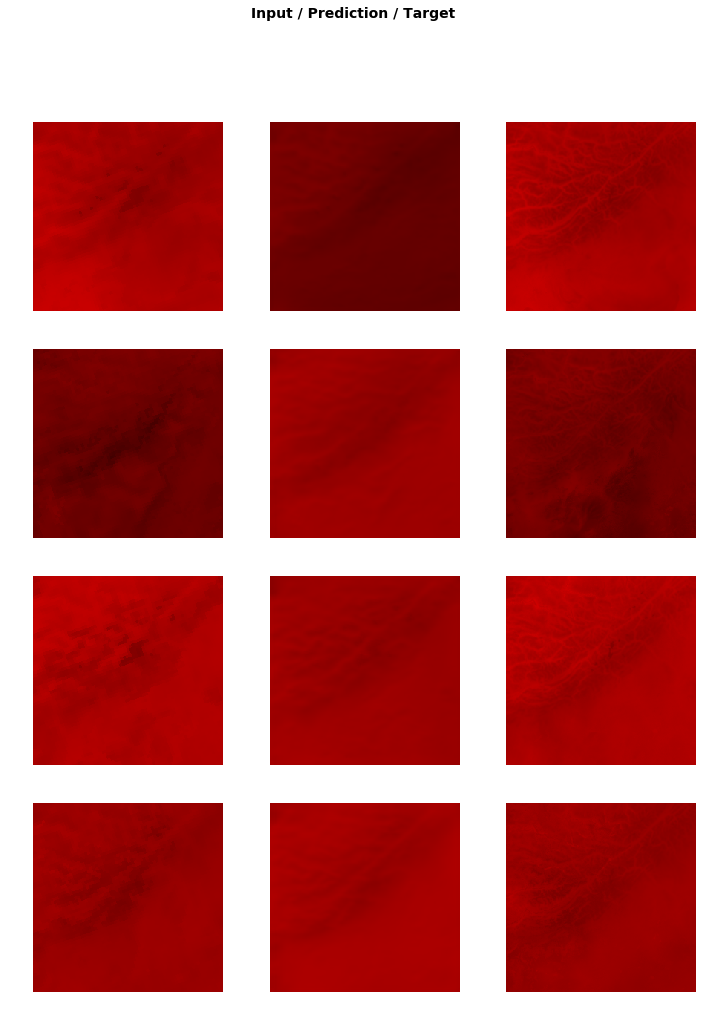

In [14]:
learn_gen.show_results(rows=4)